<a href="https://colab.research.google.com/github/Superkon3000/MegaDetector/blob/main/MegaDetector_Testing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Datensatz generieren*

In [ ]:
# download raw plittersdorf dataset
!pip install zenodo-get
!mkdir -p /content/plittersdorf/raw /content/plittersdorf/frames
!(cd "/content/gdrive/My Drive/plittersdorf/videos" && zenodo_get 10.5281/zenodo.6992653)

In [ ]:
# install socrates
!pip install av onnxruntime-gpu
!(cd /content && git clone https://github.com/timmh/socrates.git)
!(cd /content/socrates/weights/crestereo && ./download.sh)
!cp -f "/content/gdrive/My Drive/plittersdorf/scripts/extract_images_adaptive.py" /content/socrates/utils/

In [ ]:
# extract frames and infer disparity
!(cd /content/socrates && python utils/extract_images_adaptive.py "/content/gdrive/My Drive/plittersdorf/videos" "/content/gdrive/My Drive/plittersdorf/images/unclassified" "/content/gdrive/My Drive/plittersdorf/images/training" --min_sampling_interval 30 --min_video_extraction 15 --force_overwrite)

# Initialisierung

### Drive mount

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="garbage_collection_threshold:0.8"
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

drive_path = "/content/gdrive/My Drive/plittersdorf"

local_drive_path = "/content/plittersdorf"

Mounted at /content/gdrive


### Daten aus Daten aus Google Drive auf lokalen Speicher kopieren

In [3]:
# !sudo apt install rclone
# -> Beta von rclone behebt nil-pointer crash
!sudo -v ; curl https://rclone.org/install.sh | sudo bash -s beta

# Falls curl nicht funktioniert, siehe install skripts im Drive

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4669  100  4669    0     0   3950      0  0:00:01  0:00:01 --:--:--  3950
Archive:  rclone-beta-latest-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/README.html  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/rclone.1  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/git-log.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.61.0-beta.6607.450c36640-linux-amd64/rclone  [binary]
Purging old database entries in /usr/share/man...
Processing manual pages under /usr/share/man...
Purging 

In [4]:
# Token sollte weiterhin funktionieren; ansonsten `rclone config` ausführen und neuen Token mit Client Id und Secret generieren
# (beides eigentlich nicht in der .cfg nötig)

with open("rclone.cfg", "w") as f:
    f.write("""
[gdrive_plittersdorf]
type = drive
scope = drive
client_id = 601249757223-punuvsfvevoa02r7a3jbrb8rmolaqjkk.apps.googleusercontent.com
client_secret = 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
token = {"access_token":"ya29.a0Aa4xrXNTnSE8kjlsj9eZXRXF6RG3pw-YXttIucyTea3CLEfPc8E6UzgTrHFNXJFkm_9_oN9XpLfLOfTlt6p-ZKSOaL21g5ZfvaH904Zvp7GCVQ94rlOX_x6bixn9NAUpjXQq7jKfiZkEiZWcYqy909igmCRuaCgYKAbsSARESFQEjDvL9VppjJGUznfPxVZv5YWS3uw0163","token_type":"Bearer","refresh_token":"1//099o6FGFrPwguCgYIARAAGAkSNwF-L9IrMEL2FOKCgqrGbKVoc6b4bvOjD-lKFyCREOsLc4EtJxQkOGiQejjzOPBPVqQYxOc8yCE","expiry":"2022-11-04T19:03:34.2202261+01:00"}
team_drive = 
    """)

In [5]:
available_datasets = []

In [6]:
!rclone --config /content/rclone.cfg sync gdrive_plittersdorf:/plittersdorf/classification /content/plittersdorf/classification

Nur RGB-Daten laden

In [ ]:
!rclone --config /content/rclone.cfg sync gdrive_plittersdorf:/plittersdorf/images /content/plittersdorf/images --include "*.png"
available_datasets.append('noDepth')

^C


Alle Daten laden

In [ ]:
!rclone --config /content/rclone.cfg sync gdrive_plittersdorf:/plittersdorf/images /content/plittersdorf/images
available_datasets.append('depth')
available_datasets.append('noDepth')

# Definitionen

### Imports

In [ ]:
# Erneute Definition, damit beim Neustart die Initialisierung ignoiert werden kann
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="garbage_collection_threshold:0.8"
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [ ]:
import cv2
import random
import time
import json
import gc
import math
import numpy as np
from datetime import datetime
from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms

from PIL import Image

### Variablen

In [ ]:
drive_path          = "/content/gdrive/My Drive/plittersdorf"
local_drive_path    = "/content/plittersdorf"
device              = torch.device(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

model_architecture  = inputSizeX = inputSizeY = training_batch_size = depth = validation_batch_size = learning_rate = weight_decay = loss_fkt_name = optimizer_name = completed_epochs = None

In [ ]:
training_path       = os.path.join(local_drive_path if os.path.exists(os.path.join(local_drive_path, 'images/training/')) else drive_path, 'images/training/')
validation_path     = os.path.join(local_drive_path if os.path.exists(os.path.join(local_drive_path, 'images/validation/')) else drive_path, 'images/validation/')
target_path         = os.path.join(local_drive_path if os.path.exists(os.path.join(local_drive_path, 'classification/classification.json')) else drive_path, 'classification/classification.json')
feature_maps_path   = os.path.join(local_drive_path if os.path.exists(os.path.join(local_drive_path, 'classification/STs.pt')) else drive_path, 'classification/STs.pt')
model_path          = os.path.join(drive_path, 'models/')
runs_info_file      = os.path.join(drive_path, 'runs_info.json')
device              = torch.device(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

In [ ]:
TEST_MODE           = True

#### Text Prompts

In [ ]:
T_run_available     = "Angegebener Run ist vorhanden und wird geladen\nDie Parameter der nächsten Zelle werden ignoriert"
T_run_not_available = "Angegebener Run ist nicht vorhanden\nBitte Parameter angeben"
T_test_mode         = "Da im Test-Modus: kein Run wird gespeichert"

### Methoden

In [ ]:
### Laden von vorhandenen Runs

# Datei erstellen, wenn noch nicht vorhanden
if (not os.path.isfile(runs_info_file)):
    print("neue info datei erstellen...")
    leer = {}
    json_object = json.dumps(leer)
    with open(runs_info_file, "w+") as outfile:
      outfile.write(json_object)

def generateRun(description, init_date, model_architecture, completed_epochs, inputSizeX, inputSizeY, 
                training_batch_size, validation_batch_size, learning_rate, weight_decay, depth, 
                targets, loss_fkt, optimizer):
    x = {
        "description": description,
        "init_date": init_date,
        "model_architecture": model_architecture,
        "completed_epochs": completed_epochs,
        "inputSizeX": inputSizeX,
        "inputSizeY": inputSizeY,
        "training_batch_size": training_batch_size,
        "validation_batch_size": validation_batch_size,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "depth": depth,
         "targets": targets,
        "loss_fkt": loss_fkt,
        "optimizer": optimizer,
    }
    return x

def getRun(name):
    with open(runs_info_file, "r") as f:
        runs_info_data = json.load(f)
        if (name in runs_info_data):
            return runs_info_data[name]
    return None

def writeRun(name, data):
    runs_info_data = None
    with open(runs_info_file, "r") as f:
        runs_info_data = json.load(f)
    runs_info_data[name] = data
    json_object = json.dumps(runs_info_data)
    with open(runs_info_file, "w") as f:
        f.write(json_object)
    return

def updateRun(name, description = None, init_date = None, model_architecture = None, completed_epochs = None, 
              inputSizeX = None, inputSizeY = None, training_batch_size = None, validation_batch_size = None, 
              learning_rate = None, weight_decay = None, depth = None, targets = None, loss_fkt = None, optimizer = None):
    data = getRun(name)
    assert data is not None, "Der Run existiert nicht"
    newData = generateRun(
        data["description"]           if description == None            else description,
        data["init_date"]             if init_date == None              else init_date,
        data["model_architecture"]    if model_architecture == None     else model_architecture,
        data["completed_epochs"]      if completed_epochs == None       else completed_epochs,
        data["inputSizeX"]            if inputSizeX == None             else inputSizeX,
        data["inputSizeY"]            if inputSizeY == None             else inputSizeY,
        data["training_batch_size"]   if training_batch_size == None    else training_batch_size,
        data["validation_batch_size"] if validation_batch_size == None  else validation_batch_size,
        data["learning_rate"]         if learning_rate == None          else learning_rate,
        data["weight_decay"]          if weight_decay == None           else weight_decay,
        data["depth"]                 if depth == None                  else depth,
        data["targets"]               if targets == None                else targets,
        data["loss_fkt"]              if loss_fkt == None               else loss_fkt,
        data["optimizer"]             if optimizer == None              else optimizer,
    )
    writeRun(name, newData)
  
def listRuns(detailed=False):
    with open(runs_info_file, "r") as f:
        runs_info_data = json.load(f)
        for run in runs_info_data:
            print(f"'{run}' - {runs_info_data[run]['description']}")
            if detailed:
                for prop in runs_info_data[run]:
                    print(f"    {prop}: {runs_info_data[run][prop]}")

# **Run Setup**

In [ ]:
listRuns()

'6_Netzvergleich_Large' - Einfaches Training mit MobileNet Large zum Vergleichen
'6_Netzvergleich_Small_Konfidenzwerte' - Erstes Benutzen von Konfidenzwerten als STs mit SMALL
'4_Erstes_Training' - Das erste, einigermaßen funktionierende Training
'6_Netzvergleich_MNas 1.0 (1)' - Training mit MNasNet, skaliert mit normaler Tiefe; Training Nr. 1 von 2, da ausversehen doppelt trainiert
'6_Netzvergleich_MNas 1.0 (2)' - Training mit MNasNet, skaliert mit normaler Tiefe; Training Nr. 2 von 2, da ausversehen doppelt trainiert
'6_Netzvergleich_MNas 1.3' - Training mit MNasNet, skaliert mit Faktor 1,3 für die Tiefe
'7_Erstes_ADAM_Training' - Erster Trainingsversuch mit ADAM, keine sinnvollen Ergebnisse
'7_Zweites_ADAM_Training' - Zweiter Trainingsversuch mit ADAM, weight decay und geringere Lernrate sorgen für leeeeeicht besseres Ergebnis
'7_SGD-Depth' - Erneutes Training mit SGD auf Datensatz ohne Tiefendaten, gab schneller bessere Ergebnisse als mit Tiefendaten
'7_SGD+Depth' - Erneutes Traini

**Vorhandenen Run auswählen oder Name eines neuen Runs angeben**

In [ ]:
######################################################
RUN = "TESTING"
######################################################

In [ ]:
assert len(RUN)>0
print(T_run_available) if getRun(RUN) is not None else print(T_run_not_available)
if TEST_MODE:
    print(T_test_mode)

Angegebener Run ist nicht vorhanden
Bitte Parameter angeben
Da im Test-Modus: kein Run wird gespeichert


In [ ]:
######################################################
### Kurze Beschriebung des Runs ###
description             = "test"

### Grundlegende Architektur, auf der Trainiert werden soll ###
model_architecture      = "mobilenet_v3_small"

### Dimensionen des Eingabebilds ###
inputSizeX              = 1920
inputSizeY              = 1000

### Batchgrößen ###
training_batch_size     = 16
validation_batch_size   = 16

### Lernraten ###
learning_rate           = 0.0001
# weight_decay wird bei ADAM genutzt
weight_decay            = 0.00001
# Einfluss der Feature-Maps in den Loss; 0 fürs deaktivieren
feature_map_weight      = 0.1   # TODO: Ordentlich hinzufügen

### Ob Tiefendaten genutzt werden sollen ###
depth                   = False

### Mit welchen Targets trainiert werden soll ###
targets                 = "binary"

### Loss-Funktion ###
loss_fkt                = "BCELoss"

### Optimizer ###
optimizer               = "ADAM"
######################################################

### Run laden/speichern

In [ ]:
RUN_DATA = getRun(RUN)

if (RUN_DATA is None):
    print("---- NEUER RUN ----")
    init_date               = datetime.now().strftime('%Y_%m_%d_%H.%M.%S')
    completed_epochs        = 0
    if not TEST_MODE:
        writeRun(RUN, generateRun(description, init_date, model_architecture, completed_epochs, inputSizeX, inputSizeY, training_batch_size, validation_batch_size, learning_rate, weight_decay, depth, targets, loss_fkt, optimizer))
else:
    print(f"---- RUN: {RUN} ----")
    description             = RUN_DATA["description"]
    model_architecture      = RUN_DATA["model_architecture"]
    init_date               = RUN_DATA["init_date"]
    completed_epochs        = RUN_DATA["completed_epochs"]
    inputSizeX              = RUN_DATA["inputSizeX"]
    inputSizeY              = RUN_DATA["inputSizeY"]
    training_batch_size     = RUN_DATA["training_batch_size"]
    validation_batch_size   = RUN_DATA["validation_batch_size"]
    learning_rate           = RUN_DATA["learning_rate"]
    weight_decay            = RUN_DATA["weight_decay"]
    depth                   = RUN_DATA["depth"]
    targets                 = RUN_DATA["targets"]
    loss_fkt                = RUN_DATA["loss_fkt"]
    optimizer               = RUN_DATA["optimizer"]

---- NEUER RUN ----


In [ ]:
available_architectures = ["mobilenet_v3_small", "mobilenet_v3_large", "mnasnet1_0", "mnasnet1_3"]
available_targets = ["binary", "confidence"]
available_loss_fkts = ["BCELoss"]
available_optimizers = ["SGD", "ADAM"]

assert model_architecture in available_architectures, "Keine gültige Architektur angegeben"

assert inputSizeX > 0 and inputSizeY > 0 and training_batch_size > 0 and validation_batch_size > 0, "Keine negativen Werte"

if optimizer == "ADAM":
    assert weight_decay is not None, "Beim ADAM-Optimizer einen weight_decay angeben"

# if depth:
#     assert "depth" in available_datasets, f"Es ist kein Datensatzmit Tiefendaten geladen"

assert targets in available_targets, "Kein gültiges Target"

assert loss_fkt in available_loss_fkts, "Keine gültige Loss-Funktion angegeben"

assert optimizer in available_optimizers, "Kein gültige Optimizer angegeben"

# *Datenanalyse*

In [ ]:
# DATA ANALYSIS GENERATOR
# läd die Trainings und Validierungsdaten von Drive in all_data und val_data generiert entsprechende
# dicts zur besseren Verarbeitung und Analyse

all_data = os.listdir(os.path.join(local_drive_path if os.path.isdir(local_drive_path) else drive_path, 'images/training/'))
datapoints = [e for e in all_data if ".exr" in e]
datapoints.sort()
videos = {}
for image in datapoints:
  origin, frame = image.replace(".exr", "").split("_")
  if (origin not in videos):
    videos[origin] = []
  videos[origin].append(frame)

val_data = os.listdir(os.path.join(local_drive_path if os.path.isdir(local_drive_path) else drive_path, 'images/validation/'))
datapoints_val = [e for e in val_data if ".exr" in e]
datapoints_val.sort()
videos_val = {}
for image in datapoints_val:
  origin, frame = image.replace(".exr", "").split("_")
  if (origin not in videos_val):
    videos_val[origin] = []
  videos_val[origin].append(frame)

videos_target = {}
with open(target_path, 'r') as f:  
    data = json.load(f)
    # key "max_detection_conf" gibt für jedes Bild die höchste Detection an
    for image in data['images']:
        videos_target[image["file"].replace(".png", "")] = image["max_detection_conf"]

In [ ]:
# DATA FIXING
# Analysiert die Daten auf Korrektheit (passende und zusammengehörende Datenpunkte) sowie Dopplungen und Überschneidungen

# 15728 Alle Dateien
# 2365 müssten falsch sein
# 2319 mit _R
# 10230 png -> fixed: 7864
# 7864 exr      [e for e in all_data if ".exr" in e]
# 7864 exr mit zugehörigem png + vice versa
# 2366 png ohne zugehöriges exr       [e for e in all_data if ".png" in e and e.replace(".png", ".exr") not in all_data]
print(" TRAINING DATA")
correct_data_train =  [e for e in all_data if ".exr" in e and e.replace(".exr", ".png") in all_data]
print("Korrekte Datenpunkte:", len(correct_data_train))
other_data = [e for e in all_data if (".exr" in e and e.replace(".exr", ".png") not in all_data) or (".png" in e and e.replace(".png", ".exr") not in all_data)]
print("Datenpunkte ohne Partner:", len(other_data), " (rechnerisch:", len(all_data) - len(correct_data_train)*2, ")", "" if len(other_data) == 0 else " !!! sollte 0 sein !!!")
# Entfernen falscher Daten
for invalid_datapoint in other_data:
  os.remove(os.path.join(local_drive_path, 'images/training/', invalid_datapoint))

print(" VALIDATION DATA")
correct_data_val =  [e for e in val_data if ".exr" in e and e.replace(".exr", ".png") in val_data]
print("Korrekte Datenpunkte:", len(correct_data_val))
other_data = [e for e in val_data if (".exr" in e and e.replace(".exr", ".png") not in val_data) or (".png" in e and e.replace(".png", ".exr") not in val_data)]
print("Datenpunkte ohne Partner:", len(other_data), " (rechnerisch:", len(val_data) - len(correct_data_val)*2, ")", "" if len(other_data) == 0 else " !!! sollte 0 sein !!!")

schnittmenge = list(set(all_data) & set(val_data))
print("Schnittmenge:", len(schnittmenge), "" if len(schnittmenge) == 0 else " !!! sollte 0 sein !!!")
if (len(schnittmenge) > 0):
  print(schnittmenge)

print(" TARGET DATA")
no_targets = []
for image in correct_data_train + correct_data_val:
  if image.replace(".exr", "") not in videos_target:
    no_targets.append(image)
print("Datenpunkte ohne Targets:", len(no_targets), "" if len(no_targets) == 0 else " !!! sollte 0 sein !!!")
if (len(no_targets) > 0):
  print(no_targets)


# for image in schnittmenge:
#   path = os.path.join(os.path.join(local_drive_path, 'images/training/'), image)
#   os.remove(path)
#   print("Deleted:", path)

 TRAINING DATA
Korrekte Datenpunkte: 2029
Datenpunkte ohne Partner: 0  (rechnerisch: 0 ) 
 VALIDATION DATA
Korrekte Datenpunkte: 914
Datenpunkte ohne Partner: 0  (rechnerisch: 0 ) 
Schnittmenge: 0 
 TARGET DATA
Datenpunkte ohne Targets: 0 


In [ ]:
# DATA ANALYSIS ANALYZER
# graphische Darstellung der Trainingsdaten
# welches dict ausgegeben werden soll, muss in analysis_obj definiert werden

length = []
c = 0
abschneiden_bei = 15

# zu analysierende Datenmenge
analysis_obj = videos_val

for video in analysis_obj:
  length.append(len(analysis_obj[video]))

length.sort()
print("#Datenpunkte:", sum(length))
print("Durchschnittslänge", sum(length)/len(length))

keys = list(analysis_obj.keys())
keys.sort(key=lambda x: len(analysis_obj[x]), reverse=True)
for video in keys:
  print(video,"|" * len(analysis_obj[video]), "-", len(analysis_obj[video]))
  if (len(analysis_obj[video]) < abschneiden_bei):
    c = c + 1
print("#Mit weniger als", abschneiden_bei, ":", c)

# Duplicate Finder
# import collections
# print(len([item for item, count in collections.Counter(all_data).items() if count > 1]))

#Datenpunkte: 66
Durchschnittslänge 5.5
20220209151449 |||||||||| - 10
20220209150921 ||||||||| - 9
20220209151637 |||||||| - 8
20220209150741 |||||| - 6
20220209151344 |||||| - 6
20220209150523 |||| - 4
20220209150633 |||| - 4
20220209151026 |||| - 4
20220209151740 |||| - 4
20220209151844 |||| - 4
20220209151957 |||| - 4
20220209152202 ||| - 3
#Mit weniger als 15 : 12


In [ ]:
# MAKE VALIDATION SET
# Verschieben von Daten als Validierungsdatenpunkt !!! durch zersplitterte Drive-Rechte können os Dopplungen entstehen

import shutil
import random

unclassified_path = os.path.join(drive_path, 'images/unclassified')
training_path = os.path.join(drive_path, 'images/training')
validation_path = os.path.join(drive_path, 'images/validation')
falsely_deleted_data = os.listdir("/content/gdrive/My Drive")

toValidation = []
for video in videos.keys():
  x = random.randint(0, len(videos[video])-1)
  toValidation.append(video + "_" + videos[video][x] + ".exr")
  toValidation.append(video + "_" + videos[video][x] + ".png")

print("Zu verschiebende Daten", len(toValidation))

# for image in toValidation:
#   shutil.move(os.path.join(training_path, image), os.path.join(validation_path, image))

Zu verschiebende Daten 24


In [ ]:
# Altes Aufräumen der Stereo-Bilder

print(len(all_data))
print(all_data)
print(len([e for e in all_data if ".exr" in e]))
# os.rename(os.path.join(training_path, "20220213101426_000325_L.png"), os.path.join(training_path, "20220213101426_000325.png"))
# for image in wierd_data:
#   if ("_L.png" not in image):
#     continue
#   start = os.path.join("/content/gdrive/My Drive", image)
#   dest = os.path.join(training_path, image)
#   os.remove(start)
#   print("Moved", start, "to", dest)

174
['20220209151740_000670.png', '20220209151844_000720.png', '20220209150921_000361.png', '20220213100308_000634.png', '20220209151844_000540.exr', '20220209150523_000632.png', '20220209153548_000210.png', '20220209150741_000475.png', '20220209151344_000742.png', '20220209153548_000510.png', '20220209150523_000178.png', '20220209151449_000132.png', '20220209153142_000381.png', '20220209151449_000540.png', '20220213100419_000156.png', '20220210020633_000181.png', '20220209151637_000239.png', '20220209151026_000662.exr', '20220209151637_000690.png', '20220209151026_000602.exr', '20220209150921_000211.png', '20220209150741_000300.png', '20220209150921_000121.png', '20220209151449_000148.png', '20220209150921_000449.exr', '20220209151026_000181.exr', '20220209150921_000121.exr', '20220209150921_000710.png', '20220209151449_000585.exr', '20220209151449_000090.exr', '20220210020633_000512.png', '20220209153305_000571.png', '20220209151449_000195.exr', '20220209151449_000148.exr', '20220213

In [ ]:
# TRAININGSDATA TO DRIVE
# Altes System zur Speicherung der generierten Trainingsdaten in Drive
# abgelöst durch direkte Modifikation des sokrates-skripts

import shutil

counter = 0

for video in os.listdir("/content/plittersdorf/frames"):
  # nicht mehr ausführen
  break

  # print(video)
  # continue
  if ("." in video):
    continue
  video_path = os.path.join("/content/plittersdorf/frames", video)
  tiefe = os.path.join(video_path, 'disp_crestereo')
  links = os.path.join(video_path, 'left')
  rechts = os.path.join(video_path, 'right')
  print(video_path, ":")

  for frame in os.listdir(tiefe):
    # Tiefe
    start = os.path.join(tiefe, frame)
    dest = os.path.join(training_path, video + "_" + frame)
    shutil.move(start, dest)
    print("Moved", start, "to", dest)

    # Links
    start = os.path.join(links, frame.replace(".exr", ".png"))
    dest = os.path.join(training_path, video + "_" + frame.replace(".exr", ".png"))
    shutil.move(start, dest)
    print("Moved", start, "to", dest)

    # # Rechts
    # start = os.path.join(rechts, frame.replace(".exr", ".png"))
    # dest = os.path.join(training_path, video + "_" + frame.replace(".exr", "_R.png"))
    # shutil.move(start, dest)
    # print("Copied", start, "to", dest)

    counter = counter + 1
  print("Datenpunkt kopiert:", counter)

In [ ]:
# Verbinden von Runs

import shutil

path = os.path.join(drive_path, 'runs/')

runs = []

runs_to_copy = []

NEUER_ORDNER = ''

for run in runs_to_copy:
    toMove = []
    dir = os.path.join(path, run)
    toMove += [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    if not os.path.exists(os.path.join(path, NEUER_ORDNER)):
        os.mkdir(os.path.join(path, NEUER_ORDNER))

    dir = os.path.join(path, run, 'Training vs. Validation Loss_Validation')
    toMove += [os.path.join('Training vs. Validation Loss_Validation', f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    if not os.path.exists(os.path.join(path, NEUER_ORDNER, 'Training vs. Validation Loss_Validation')):
        os.mkdir(os.path.join(path, NEUER_ORDNER, 'Training vs. Validation Loss_Validation'))

    dir = os.path.join(path, run, 'Training vs. Validation Loss_Training')
    toMove += [os.path.join('Training vs. Validation Loss_Training', f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    if not os.path.exists(os.path.join(path, NEUER_ORDNER, 'Training vs. Validation Loss_Training')):
        os.mkdir(os.path.join(path, NEUER_ORDNER, 'Training vs. Validation Loss_Training'))

    for e in toMove:
        src = os.path.join(path, run, e)
        dest = os.path.join(path, NEUER_ORDNER, e)
        print(src, dest)
        # shutil.move(src, dest)




---


# Training

### Definitionen

In [ ]:
### TRANSFORMATION

from torchvision import transforms

transformRBG = transforms.Compose([
    transforms.Resize((inputSizeX, inputSizeY)),
    transforms.ToTensor(),
    # Keine Farbbilder, nur ein Channel, der variiert wird
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

transformD = transforms.Compose([
    transforms.Resize((inputSizeX, inputSizeY)),
    transforms.ToTensor(),
])

In [ ]:
### READ TARGETS

def load_batchout(path):
    f = open(path)
  
    data = json.load(f)
    out = {}
  
    # key "max_detection_conf" gibt für jedes Bild die höchste Detection an
    for image in data['images']:
        out[image["file"].replace(".png", "")] = image["max_detection_conf"]

    f.close()
    return out

def load_featuremaps(path):
    out = torch.load(feature_maps_path)

    for t in out:
        # gpu eintrag entfernen
        out[t] = out[t].cpu()
        # Batchdimension entfernen
        out[t] = torch.squeeze(out[t])
    
    return out

In [ ]:
### DATASET CLASS

class ImageDataset(Dataset):
    def __init__(self, target_confidence, target_feature_maps, train=True):
        # Set Training/Validation Path depending on use
        self.data_path = training_path if train else validation_path

        # Anhand der .png Dateien wird der Datensatz definiert 
        self.files = [i.replace('.png', '') for i in os.listdir(self.data_path) if '.png' in i]
        self.target_confidence = target_confidence
        self.target_feature_maps = target_feature_maps
        self.image_count = len(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        current_image = self.files[idx]

        img_rgb = cv2.imread(os.path.join(self.data_path, current_image + '.png'))
        img_rgb_t = transformRBG(Image.fromarray(img_rgb))
        combined_t = img_rgb_t

        if depth:
            img_d = cv2.imread(os.path.join(self.data_path, current_image + '.exr'), cv2.IMREAD_UNCHANGED)
            img_d_t = transformD(Image.fromarray(img_d))
            combined_t = torch.cat((img_rgb_t, img_d_t), dim=0)

        if current_image not in self.target_confidence:
            # raise Exception("Unvollständige Targets für: " + current_image)
            # Damit das Netz nicht verloren geht, wird ein extra target eingefügt
            print("Unvollständige Confidence-Targets für: " + current_image)
            self.target_confidence[current_image] = 0

        label = None
        if targets == 'binary':
            label = 1. if self.target_confidence[current_image] > 0.2 else 0.
        if targets == 'confidence':
            label = self.target_confidence[current_image]

        feature_map = self.target_feature_maps[current_image + ".png"]

        assert label is not None, f"Ungültiges Target: label={label} (für targets={targets})"
        return combined_t, label, feature_map

## Config laden

### Models

In [ ]:
# md = torch.hub.load('ultralytics/yolov5', 'custom', 'https://github.com/microsoft/CameraTraps/releases/download/v5.0/md_v5a.0.0.pt')

# # prepare feature map hook
# feature_map = None
# def hook(model, input, output):
#     global feature_map
#     feature_map = output.detach()

# # register hook
# lastLayer = list(iter(md.model.model.model))[11]
# lastLayer.m.register_forward_hook(hook)

# # set MegaDetector input size
# mdInputSizeX = 640
# mdInputSizeY = 320

# # test input size
# with torch.no_grad():
#     md(torch.zeros(10, 3, mdInputSizeY, mdInputSizeX))

In [ ]:
# Hook Definieren
feature_map_own_model  = None

def hook(model, input, output):
    global feature_map_own_model
    # kein detach, damit gradienten berechnet werden (brauchen wir beim MD nicht)
    feature_map_own_model = output

In [ ]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = None

n_input_channels = 4
# if with depth, 3 otherwise
if not depth:
    n_input_channels = 3

if (model_architecture == "mobilenet_v3_small"):
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # output-layer anpassen
    model.classifier[-1] = torch.nn.Linear(in_features=1024, out_features=1, bias=True)

    # input-layer anpassen
    model.features[0][0] = torch.nn.Conv2d(n_input_channels, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # hook an letzen conv-layer setzen
    lastLayer = model.features[-1]
    lastLayer.register_forward_hook(hook)

if (model_architecture == "mobilenet_v3_large"):
    # Funktioniert mit 12.86 GB:
    # training_batch_size = 28
    # validation_batch_size = 16

    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

    # output-layer anpassen
    model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=1, bias=True)

    # input-layer anpassen
    model.features[0][0] = torch.nn.Conv2d(n_input_channels, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    # hook an letzen conv-layer setzen
    lastLayer = model.features[-1]
    lastLayer.register_forward_hook(hook)

if (model_architecture == "mnasnet1_0"):
    model = models.mnasnet1_0(weights=models.MNASNet1_0_Weights.IMAGENET1K_V1)

    # output-layer anpassen
    model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=1, bias=True)

    model.layers[0] = torch.nn.Conv2d(n_input_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

if (model_architecture == "mnasnet1_3"):
    # Funktioniert mit 12.7 GB:
    # training_batch_size = 81
    model = models.mnasnet1_3(weights=models.MNASNet1_3_Weights.IMAGENET1K_V1)

    # output-layer anpassen
    model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=1, bias=True)

    model.layers[0] = torch.nn.Conv2d(n_input_channels, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    

assert model is not None

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [ ]:
# Feature Map Modification
target_feature_maps             = load_featuremaps(feature_maps_path)
target_feature_maps_shape       = target_feature_maps[list(target_feature_maps.keys())[0]].shape

model.feature_map_modification  = torch.nn.LazyConv2d(target_feature_maps_shape[0], kernel_size=1)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# Load state_dict if already existing
netz = os.path.join(model_path, RUN)
if os.path.isfile(netz):
    model.load_state_dict(torch.load(netz))
    print("Loaded State_Dict for model")

model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss und Optimizer

In [ ]:
# Loss funktion und optimizer
loss_fkt_t = None
optimizer_t = None

if (loss_fkt == "BCELoss"):
  loss_fkt_t = nn.BCELoss()

assert loss_fkt_t is not None

if (optimizer == "SGD"):
  optimizer_t = optim.SGD(model.parameters(), lr=learning_rate)
if (optimizer == "ADAM"):
  optimizer_t = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

assert optimizer_t is not None

### DataLoaders

In [ ]:
target_confidence         = load_batchout(target_path)

training_loader           = torch.utils.data.DataLoader(ImageDataset(target_confidence, target_feature_maps, train=True), batch_size=training_batch_size, shuffle=True, num_workers=1)
validation_loader         = torch.utils.data.DataLoader(ImageDataset(target_confidence, target_feature_maps, train=False), batch_size=validation_batch_size, shuffle=True, num_workers=1)

### Training definieren

#### train

In [ ]:
def train_one_epoch(epoch_index, tb_writer, mb, max_batches_per_epoch = -1):
    global feature_map, feature_map_own_model, batched_target_feature_map
    running_loss = 0.
    last_loss = 0.
    avg_loss = 0.

    number_of_batches = len(training_loader)
    # number_of_batches/10 == 10 dokumentationspunkte in jedem Epoch
    batches_per_checkpoint = math.floor(number_of_batches/5)
    last_checkpoint = -1

    # print("number_of_batches",number_of_batches)
    # print("batches_per_checkpoint",batches_per_checkpoint)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    for i, data in progress_bar(enumerate(training_loader), parent=mb, total=number_of_batches):
        mb.child.comment = f'Training'

        # Every data instance is an input + label pair
        inputs, labels, target_feature_maps = data

        # Send to current Device
        inputs, labels, target_feature_maps = inputs.to(device), labels.to(device), target_feature_maps.to(device)

        # Zero your gradients for every batch!
        optimizer_t.zero_grad()

        # Make predictions for this batch
        # print(f"Iteration {i}: Before pass", torch.cuda.memory_allocated(device))
        outputs = model(inputs)
        ### AKTIVIERUNGSFUNKTION ###
        outputs = torch.sigmoid(outputs)
        # print("                After pass", torch.cuda.memory_allocated(device))

        if TEST_MODE:
            mb.write(f"allocated memory: {torch.cuda.memory_allocated(device) / 1e+9} GB")

        # Feature maps von MegaDetector in die globale Variable laden
        
        # with torch.no_grad():
        #     md_inputs = inputs[:,0:3]
        #     md_inputs = F.interpolate(md_inputs, (mdInputSizeY, mdInputSizeX), mode="bilinear")
        #     md(md_inputs)

        

        # print("target_feature_maps", target_feature_maps.size())

        # Dimensionsanpassung
        labels = torch.unsqueeze(labels, dim=1)

        # Compute the loss and its gradients
        loss = loss_fkt_t(outputs, labels.float())
        if feature_map_weight != 0:
            # print("labels", labels.size())
            # print("feature_map_own_model", feature_map_own_model.size())

            # Feature maps von eigenem Model anpassen
              # Dim 1 mit Convolution anpassen
            feature_map_own_model = model.feature_map_modification(feature_map_own_model)   # ==  torch.nn.LazyConv2d(feature_map.shape[1], kernel_size=1)
            # print("->", feature_map_own_model.size())

              # Dim 2 und 3 mit Interpolation anpassen
            feature_map_own_model = F.interpolate(feature_map_own_model, target_feature_maps_shape[1:3], mode="bilinear").detach()
            # print("->", feature_map_own_model.size())

            loss = loss + feature_map_weight * F.mse_loss(feature_map_own_model, target_feature_maps)
        loss.backward()

        # Adjust learning weights
        optimizer_t.step()


        # Gather data and report
        running_loss += loss.item()
        if i % batches_per_checkpoint == batches_per_checkpoint - 1 or i == number_of_batches - 1:
            last_loss = running_loss / (i - last_checkpoint) # loss per batch
            mb.write(f'  Batch {(i+1):3}/{number_of_batches} - loss: {last_loss:.5f}')

            # loss zum durchschnitt hinzufügen; bei maximaler Batchzahl muss durch diese geteilt werden
            avg_loss += running_loss / (number_of_batches if max_batches_per_epoch == -1 else max_batches_per_epoch)

            # jeder Wert der x Achse ist eine Batch
            tb_x = epoch_index * number_of_batches + i
            if not TEST_MODE:
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            last_checkpoint = i

        # Custom Abbruch für kürzeres Training nach entsprechenden Batches
        if max_batches_per_epoch != -1 and i >= max_batches_per_epoch:
            mb.write(f"  Ending Epoch {epoch_index} after {i} batches")
            return avg_loss

    return avg_loss

#### validate

In [ ]:
def validate(tb_writer, mb, max_batches_per_epoch = -1):
    global feature_map, feature_map_own_model
    with torch.no_grad():
        number_of_batches = len(validation_loader)

        running_vloss = 0.0
        for i, vdata in progress_bar(enumerate(validation_loader), parent=mb, total=number_of_batches):
            mb.child.comment = f'Validierung'

            vinputs, vlabels, vtarget_feature_maps = vdata
            # Send to current Device
            vinputs, vlabels, vtarget_feature_maps = vinputs.to(device), vlabels.to(device), vtarget_feature_maps.to(device)

            # print(f"Validation {i}: Before pass", torch.cuda.memory_allocated(device))
            voutputs = model(vinputs)
            ### AKTIVIERUNGSFUNKTION ###
            voutputs = torch.sigmoid(voutputs)
            # print("                After pass", torch.cuda.memory_allocated(device))

            # Feature maps von MegaDetector in die globale Variable laden
            # with torch.no_grad():
            #     md_inputs = vinputs[:,0:3]
            #     md_inputs = F.interpolate(md_inputs, (mdInputSizeY, mdInputSizeX), mode="bilinear")
            #     md(md_inputs)
            
            
            if TEST_MODE:
                mb.write(f"allocated memory: {torch.cuda.memory_allocated(device) / 1e+9} GB")

            # Batch-Dimensionsanpassung
            vlabels = torch.unsqueeze(vlabels, dim=1)
            vloss = loss_fkt_t(voutputs, vlabels.float())
            if feature_map_weight != 0:
                feature_map_own_model = model.feature_map_modification(feature_map_own_model)
                feature_map_own_model = F.interpolate(feature_map_own_model, target_feature_maps_shape[1:3], mode="bilinear").detach()

                vloss = vloss + feature_map_weight * F.mse_loss(feature_map_own_model, vtarget_feature_maps)
            running_vloss += vloss.item()

            if MAX_ENUMERATIONS_VAL != -1 and i >= MAX_ENUMERATIONS_VAL:
                mb.write(f"  Ending Validation after {i} batches")
                break

    avg_vloss = running_vloss / len(validation_loader)

    return avg_vloss

### Darstellung

In [ ]:
def printTraining():
    if TEST_MODE:
        print("   ***** TESTMODUS *****\n       (kein Speichern)")
    print(f"Trainingsbeginn: {datetime.now().strftime('%Y_%m_%d_%H.%M.%S')}")
    print(f"Speicherort: '{os.path.join(model_path, RUN)}'")
    
    print("")

In [ ]:
def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

## Trainieren

In [ ]:
printTraining()

writer = None
if not TEST_MODE:
    writer = SummaryWriter(os.path.join(drive_path, f'runs/{RUN}'))

EPOCHS = 50

# Debug; -1 für alle Daten
MAX_ENUMERATIONS_TRAIN = -1
MAX_ENUMERATIONS_VAL = -1
if TEST_MODE:
  MAX_ENUMERATIONS_TRAIN = MAX_ENUMERATIONS_VAL = 5

best_vloss = 1_000_000.

# Progressbar setup
mb = master_bar(range(completed_epochs + 1, EPOCHS + 1))
mb.names = ['Trainings-Loss', 'Validierungs-Loss']
train_loss_history, valid_loss_history = [], []

for epoch in mb:
    mb.write(f'EPOCH {epoch}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, writer, mb, MAX_ENUMERATIONS_TRAIN)
    # print("vor zero grad", torch.cuda.memory_allocated(device))
    optimizer_t.zero_grad() # bringt keine speicherverbesserung
    # print("nach zero grad", torch.cuda.memory_allocated(device))


    # We don't need gradients on to do reporting
    model.train(False)
    avg_vloss = validate(writer, mb, MAX_ENUMERATIONS_VAL)


    mb.write(f'=> LOSS - train: {avg_loss:.5f}, valid: {avg_vloss:.5f}')
    
    train_loss_history.append(avg_loss)
    valid_loss_history.append(avg_vloss)

    plot_loss_update(epoch, EPOCHS, mb, train_loss_history, valid_loss_history)

    # Log the running loss averaged per batch
    # for both training and validation
    if not TEST_MODE:
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch)
        writer.flush()

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), os.path.join(model_path, f"{RUN}_best"))

        torch.save(model.state_dict(), os.path.join(model_path, f"{RUN}"))

        updateRun(RUN, completed_epochs=epoch)

   ***** TESTMODUS *****
       (kein Speichern)
Trainingsbeginn: 2022_12_08_12.33.44
Speicherort: '/content/gdrive/My Drive/plittersdorf/models/TESTING'



labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])
labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])
labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])
labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])
labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])
labels torch.Size([16, 1])
feature_map_own_model torch.Size([16, 576, 60, 32])
-> torch.Size([16, 640, 60, 32])
-> torch.Size([16, 640, 6, 10])


KeyboardInterrupt: ignored

# Trainingsanalyse

In [ ]:
listRuns()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/content/gdrive/MyDrive/plittersdorf/runs

# MegaDetector

In [ ]:
# load MegaDetector
md = torch.hub.load('ultralytics/yolov5', 'custom', 'https://github.com/microsoft/CameraTraps/releases/download/v5.0/md_v5a.0.0.pt')

targetFile = os.path.join(drive_path, 'classification/STs.pt')

# prepare feature map hook
feature_map = None
def hook(model, input, output):
    global feature_map
    feature_map = output.detach()

# register hook
lastLayer = list(iter(md.model.model.model))[11]
lastLayer.m.register_forward_hook(hook)

t_data = os.listdir(os.path.join(drive_path, 'images/training/'))
v_data = os.listdir(os.path.join(drive_path, 'images/validation/'))
datapoints = [os.path.join('images/training/', e) for e in t_data if ".png" in e] + [os.path.join('images/validation/', e) for e in v_data if ".png" in e]

f_maps = {}

backup_c = 3

print(len(datapoints))
for image in progress_bar(datapoints):
    save_name = image.split("/")[-1]
    backup_c -= 1

    md(os.path.join(drive_path, image))
    f_maps[save_name] = feature_map
    if backup_c <= 0:
        backup_c = 100

        torch.save(f_maps, targetFile)

        print("**Wrote to File**")
    print(image, "done")


torch.save(f_maps, targetFile)

In [ ]:
out = torch.load(os.path.join(drive_path, 'classification/STs.pt'))
print(out)

t_data = os.listdir(os.path.join(drive_path, 'images/training/'))
v_data = os.listdir(os.path.join(drive_path, 'images/validation/'))
datapoints = [os.path.join('images/training/', e) for e in t_data if ".png" in e] + [os.path.join('images/validation/', e) for e in v_data if ".png" in e]
print(len(datapoints))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8867


In [ ]:
# prepare feature map hook
feature_map = None
def hook(model, input, output):
    global feature_map
    feature_map = output.detach()

# register hook
lastLayer = list(iter(md.model.model.model))[11]
lastLayer.m.register_forward_hook(hook)

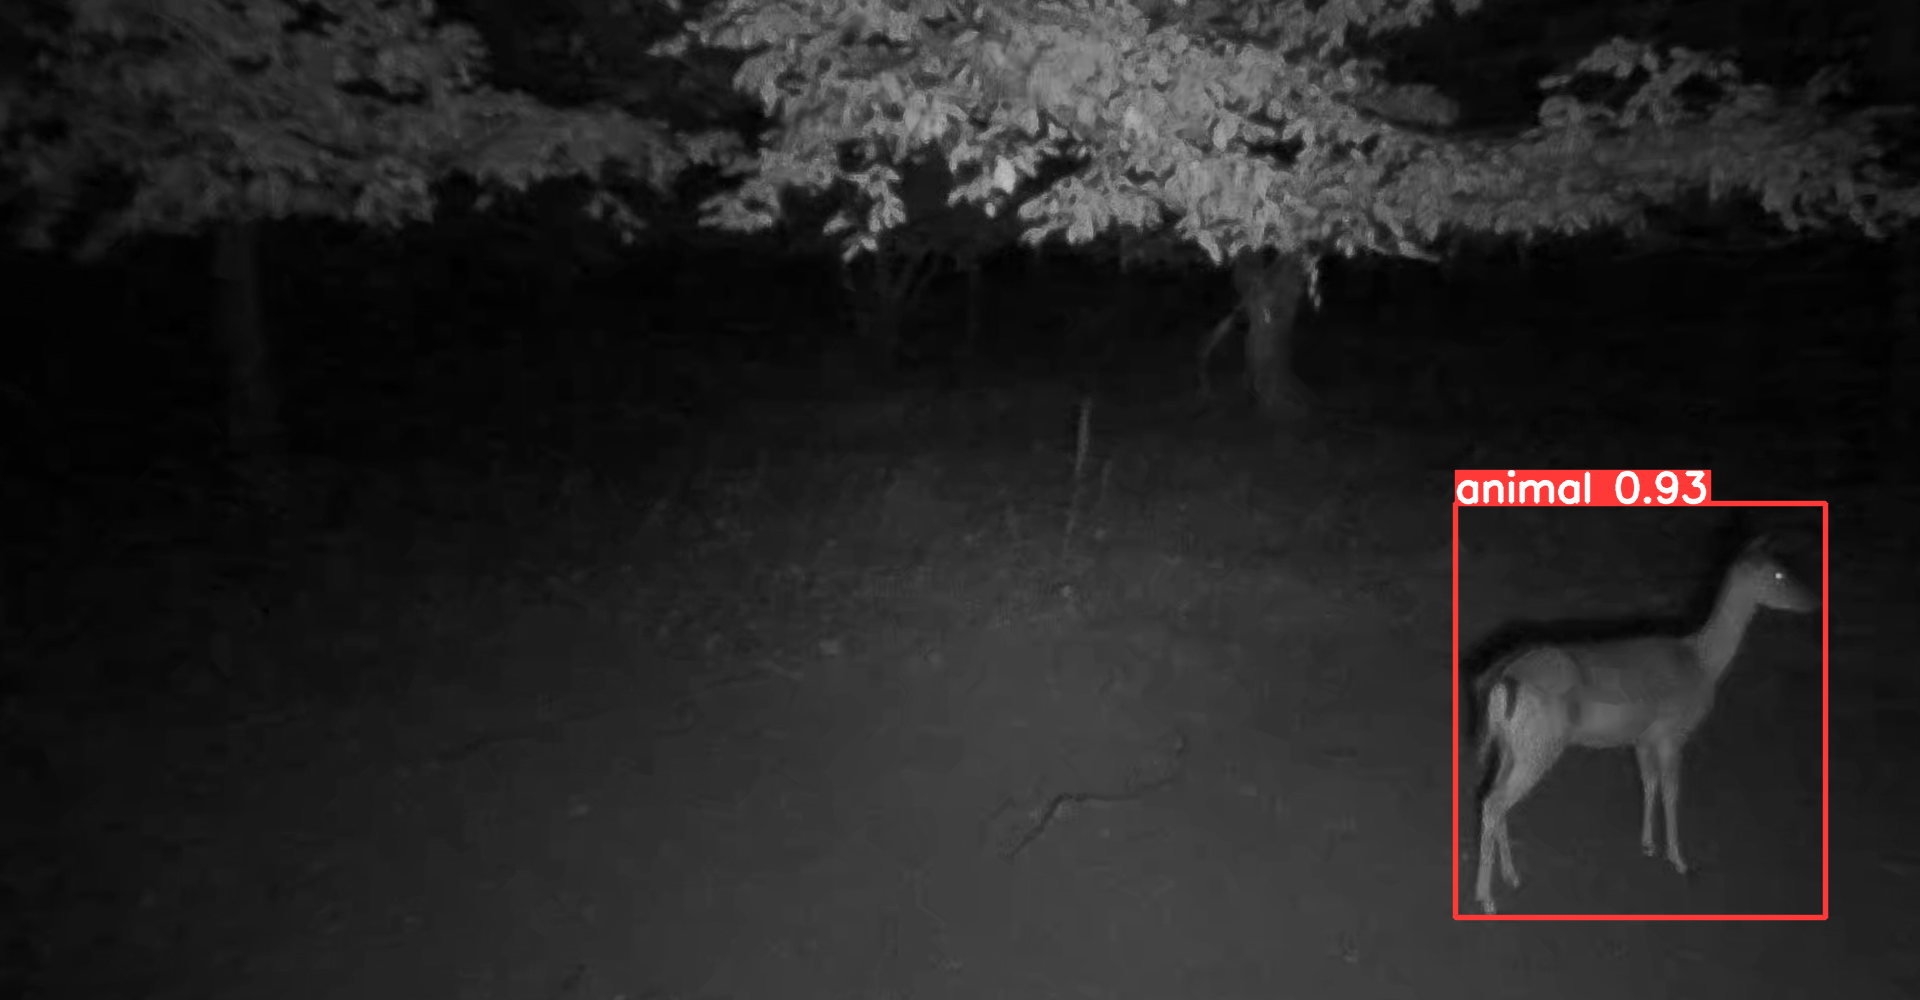

tensor([[[[1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861],
          [1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861],
          [1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861],
          [1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861],
          [1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861],
          [1.80861, 1.80861, 1.80861,  ..., 1.80861, 1.80861, 1.80861]],

         [[1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560],
          [1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560],
          [1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560],
          [1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560],
          [1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560],
          [1.81851, 1.81851, 1.81851,  ..., 1.54560, 1.54560, 1.54560]],

         [[0.97497, 0.97497, 0.97497,  ..., 0.97497, 0.97497, 0.58848],
          [0.97497, 0.97497, 0.97497,  ..., 0.97497, 0.97497

In [ ]:
# forward some image
results = md(os.path.join(training_path, '20220615005017_000271.png'))

# show results
results.show()  # .print(), .show(), .save(), .crop(), .pandas(), etc.

# show feature map obtained using hook
print(feature_map)
print(feature_map.size())
# [1, 640, 6, 10]